# Deep Learning for NLP with Keras


This notebook is meant to give you the tools to get started with using neural networks.
We'll be using the toolkit Keras, which is a very up-to-date and sufficiently high-level Python package for quick development of Deep Learning systems.

In this workshop, we'll be focussing on approaches relevant to NLP.
We'll cover both a simple classification setting, as well as a sequence prediction setting.


<img src="files/flowchart.png">

<img src="files/neural_network_1.tiff">

<img src="files/neural_network_multiclass.tiff">

<img src="files/multiclass_onehot.tiff">

In [110]:
# Begin by trying to import the necessary packages (click this cell, and then Shift+Enter)

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1337)  # Freeze seeds for reproducibility
import keras
#from keras.utils.visualize_util import plot as keras_plot
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

from codecs import open
from collections import defaultdict

# Prepare word/tag to ID conversions
fillers = ('<w>', '</w>', '<PAD>', '_UNK')
word_to_id = defaultdict(lambda: len(word_to_id)+1) # 0 for padding
tag_to_id = defaultdict(lambda: len(tag_to_id)+1)
for word in fillers:
    word_to_id[word]
    if word != '_UNK':
        tag_to_id[word]
    
print('Success!')

Success!


If that worked, you're good to go!

Next, load these predefined functions for reading and preparing data for our neural networks.

In [75]:
def read_ffnn_data(fname, delimiter='\t'):
    '''Read data from a tsv file with format: <word<TAB>tag<NEWLINE>'''
    X, y = [], []
    with open(fname, 'r', encoding='utf-8') as in_f:
        for line in in_f:
            if len(line) <= 2: continue
            word, tag = line.strip().split(delimiter)
            X.append([word_to_id.get(word, word_to_id['_UNK'])])
            y.append(tag_to_id[tag])
            
    return X, y

def read_rnn_data(fname, delimiter='\t'):
    '''
    Read data from a tsv file with format: <word<TAB>tag<NEWLINE>,
    and blank lines between each sentence.
    '''
    X, y = [], []
    with open(fname, 'r', encoding='utf-8') as in_f:
        curr_X, curr_y = [word_to_id['<w>']], [tag_to_id['<w>']]
        for line in in_f:
            if len(line) <= 2: # i.e. newline
                if curr_X and curr_y:
                    if len(curr_X) <= 20:
                        curr_X.append(word_to_id['</w>'])
                        curr_y.append(tag_to_id['</w>'])
                        X.append(curr_X)
                        y.append(curr_y)
                    curr_X = [word_to_id['<w>']]
                    curr_y = [tag_to_id['<w>']]
                continue
            word, tag = line.strip().split(delimiter)
            curr_X.append(word_to_id.get(word, word_to_id['_UNK']))
            curr_y.append(tag_to_id[tag])
            
    # Catch last line
    if X and y:
        curr_X.append(word_to_id['</w>'])
        curr_y.append(tag_to_id['</w>'])
        X.append(curr_X)
        y.append(curr_y)
            
    return X, y

def read_word_embeddings(fname):
    '''Read an embeddings file matching the input vocab'''
    word_vec_map = {}
    with open(fname, 'r', encoding='utf-8') as in_f:
        for line in in_f:
            fields = line.strip().split()
            word = fields[0]
            embedding = np.asarray([float(i) for i in fields[1:]], dtype=np.float32)
            word_to_id[word]
            word_vec_map[word] = embedding
    
    return word_vec_map, len(embedding)

def y_to_onehot(y, n_classes):
    y_onehot = np.zeros((len(y), n_classes), dtype=np.int32)
    for idx, tag in enumerate(y):
        y_onehot[idx, tag] = 1
        
    return y_onehot

def y_to_onehot_rnn(y):
    y_onehot = np.zeros((len(y), max_sent_len, n_classes), dtype=np.int32)
    for idx, sentence in enumerate(y):
        for idy, tag in enumerate(sentence):
            if idy >= max_sent_len: break
            y_onehot[idx, idy+(max_sent_len-len(sentence)), tag] = 1
            
   # sequence.pad_sequences(y_onehot, maxlen=max_sent_len, dtype=np.int32, value=tag_to_id['<PAD>'])
            
    return y_onehot

## Feed-Forward Neural Networks

So that our neural network can make sense of our data, we'll be working with numerical IDs from here on.

We'll also load some pre-trained word representations. Such 'word embeddings' are a big part of the success of neural NLP applications. Using very simple techniques, distributional word representatiosn can be learnt both quickly and without any supervision at all.

In [26]:
word_to_vec, dimensionality = read_word_embeddings('sv.polyglot.filtered')
vocab_size = len(word_to_vec)+1
embedding_weights = np.zeros((vocab_size, dimensionality), dtype=np.float32)
for word, index in word_to_id.items():
    embedding_weights[index,:] = word_to_vec[word]


Let's have a look at how some word representations are similar/different to each other (*low = similar, high = dissimilar*).

In [27]:
gul = word_to_vec['gul']
vit = word_to_vec['vit']
usa = word_to_vec['USA']
ger = word_to_vec['Tyskland']
import scipy
print('cos(gul, vit): {0}'.format(scipy.spatial.distance.cosine(gul, vit)))
print('cos(usa, ger): {0}'.format(scipy.spatial.distance.cosine(usa, ger)))
print('cos(vit, ger): {0}'.format(scipy.spatial.distance.cosine(vit, ger)))
print('cos(usa, gul): {0}'.format(scipy.spatial.distance.cosine(usa, gul)))

cos(gul, vit): 0.199402826075
cos(usa, ger): 0.130351893484
cos(vit, ger): 0.832578361366
cos(usa, gul): 0.908857627253


Next, we'll load some Part-of-Speech (POS) data.
We'll use a subset of the Swedish Universal Dependencies POS data.

In [88]:
train_X, train_y = read_ffnn_data('sv-ud-train-small.conllu')
dev_X, dev_y = read_ffnn_data('sv-ud-dev-small.conllu')
test_X, test_y = read_ffnn_data('sv-ud-test-small.conllu')

vocab_size = len(word_to_vec)+1
n_classes = len(tag_to_id)+1

train_y_onehot = y_to_onehot(train_y, n_classes)
dev_y_onehot = y_to_onehot(dev_y, n_classes)
test_y_onehot = y_to_onehot(test_y, n_classes)

Let's have a look at the data, and calculate a simple baseline.

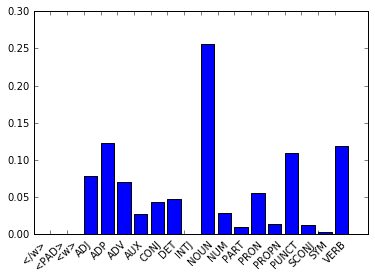

In [79]:
from collections import Counter
class_counts = Counter(train_y)

classes = [pos_class for pos_class, idx in sorted(tag_to_id.items())]
counts = [class_counts.get(tag_to_id[pos_class], 0) / float(len(train_y)) for pos_class in classes]

plt.bar(range(len(counts)), counts, tick_label=classes)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);

More than 25% of the data belongs to the 'NOUN' class. A simple baseline we can use is to assign this majority class to all instances in our test data. A more fair comparison is to compare with the most frequent class per type in the training data, rather than the training data as a whole. This is essentially what a Naïve Bayes classifier would do, given only unigram features.

In [81]:
from sklearn import naive_bayes
clf = naive_bayes.MultinomialNB()
clf.fit(y_to_onehot(train_X, vocab_size), train_y)
clf.score(y_to_onehot(dev_X, vocab_size), dev_y)

0.77934272300469487

Okay, that's a bit more challenging to beat!

For our first experiments, we're using a simple type of Neural Networks: The Feed-Forward Neural Network (FFNN).

In our case, the network will look something like this:

In [82]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Flatten
from keras.layers.embeddings import Embedding

def build_ffnn(n_layers, pretrained_embeddings):
    '''
    Build a simple Feed-Forward Neural Network.
    '''
    word_input = Input(shape=(1, ), dtype='int32', name='word_input') # One word at a time
    if pretrained_embeddings:
        word_embedding = Embedding(vocab_size, dimensionality, input_length=1, weights=[embedding_weights])(word_input)
    else:
        word_embedding = Embedding(vocab_size, dimensionality, input_length=1)(word_input)
        
    word_embedding = Flatten()(word_embedding)
    
    # Hidden layer(s)
    layer_dim = dimensionality * 2
    hidden = Dense(layer_dim)(word_embedding)
    for n in range(n_layers-1):
        hidden = Dense(layer_dim)(hidden)
        layer_dim = int(layer_dim/2.0)
    
    model_output = Dense(n_classes, activation='softmax', name='main_output')(hidden)
    model = Model(input=[word_input], output=[model_output])
    
    return model


Try running the following block, and make a note of the results.

Try changing some parameters (n layers, not using pretrained embeddings, n epochs) and see how things change.
**Is going deeper better?**

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
word_input (InputLayer)          (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_14 (Embedding)         (None, 1, 64)         849216      word_input[0][0]                 
____________________________________________________________________________________________________
flatten_7 (Flatten)              (None, 64)            0           embedding_14[0][0]               
____________________________________________________________________________________________________
dense_7 (Dense)                  (None, 128)           8320        flatten_7[0][0]                  
___________________________________________________________________________________________

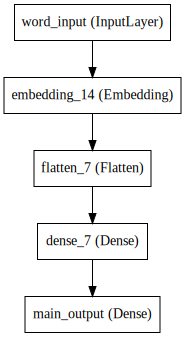

In [111]:
n_epochs = 10                # Number of epochs
n_layers = 1                 # Number of hidden layers
pretrained_embeddings = True # Using pretrained embeddings (True/False)

model = build_ffnn(n_layers, pretrained_embeddings)
model.compile(optimizer='sgd',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

model.fit(train_X, train_y_onehot, validation_data=(dev_X, dev_y_onehot), nb_epoch=n_epochs, batch_size=100, verbose=2);
print('Evaluation - test_loss: {0:.4f} - test_acc: {1:.4f}'.format(*model.evaluate(test_X, test_y_onehot, batch_size=100, verbose=2)))
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Using pre-trained embeddings, you should have gotten a test accuracy of above 80%.
Not too bad, considering the fact that we're not using any context!

Now, let's do a small error analysis:

In [91]:
def ffnn_predict_sentence(sent, model):
    word_ids = [word_to_id.get(word, word_to_id['_UNK']) for word in sent]
    preds = model.predict_on_batch(word_ids)
    pred_pos = [tag for pred in preds for tag, tag_id in tag_to_id.items() if tag_id == np.argmax(pred)]
    print('SNT: {0}'.format(sent))
    print('POS: {0}\nUNK: {1}'.format(pred_pos, [idx==word_to_id['_UNK'] for idx in word_ids]))
    

sent = u'Det känns riktigt att ha ett riktigt yrke .'.split()
ffnn_predict_sentence(sent, model)


SNT: [u'Det', u'k\xe4nns', u'riktigt', u'att', u'ha', u'ett', u'riktigt', u'yrke', u'.']
POS: [u'PRON', u'VERB', u'ADV', u'PART', u'VERB', u'DET', u'ADV', u'NOUN', u'PUNCT']
UNK: [False, False, False, False, False, False, False, False, False]


Since no context is used, the two instances of 'riktigt' incorrectly receive the same class (should be ADV, ADJ).

## Recurrent Neural Networks

Using an FFNN is often sufficient, but incorporating context information (of varying lengths) is problematic.

A solution to this, is to use Recurrent Neural Networks.
(TODO: More info)

First, we'll need to read in the data and convert it to a different format.
Whereas we used a simple 'one word, one label' format for the FFNN, we now need a format corresponding to a sentence with tags.

We also need to specify a maximum sentence length to consider - to keep things running on CPUs in a reasonable time, we'll restrict ourselves to sentences of 20 words or less.

In [96]:
from keras import backend as K
from keras.preprocessing import sequence

def actual_accuracy(act, pred):
    '''
    Calculate accuracy each batch.
    Keras' standard calculation factors in our padding classes. We don't.
    '''
    act_argm  = K.argmax(act, axis=-1)   # Indices of act. classes
    pred_argm = K.argmax(pred, axis=-1)  # Indices of pred. classes

    incorrect = K.cast(K.not_equal(act_argm, pred_argm), dtype='float32')
    correct   = K.cast(K.equal(act_argm, pred_argm), dtype='float32')
    padding   = K.cast(K.equal(K.sum(act), 0), dtype='float32')
    start     = K.cast(K.equal(act_argm, 0), dtype='float32')
    end       = K.cast(K.equal(act_argm, 1), dtype='float32')

    pad_start     = K.maximum(padding, start)
    pad_start_end = K.maximum(pad_start, end) # 1 where pad, start or end

    # Subtract pad_start_end from correct, then check equality to 1
    # E.g.: act: [pad, pad, pad, <s>, tag, tag, tag, </s>]
    #      pred: [pad, tag, pad, <s>, tag, tag, err, </s>]
    #   correct: [1,     0,   1,   1,   1,   1,   0,    1]
    #     p_s_e: [1,     1,   1,   1,,  0,   0,   0,    1]
    #  corr-pse: [0,    -1,   0,   0,   1,   1,   0,    0] # Subtraction
    # actu_corr: [0,     0,   0,   0,   1,   1,   0,    0] # Check equality to 1
    corr_preds   = K.sum(K.cast(K.equal(correct - pad_start_end, 1), dtype='float32'))
    incorr_preds = K.sum(K.cast(K.equal(incorrect - pad_start_end, 1), dtype='float32'))
    total = corr_preds + incorr_preds
    accuracy = corr_preds / total

    return accuracy

train_X_rnn, train_y_rnn = read_rnn_data('sv-ud-train.conllu')
dev_X_rnn, dev_y_rnn = read_rnn_data('sv-ud-dev.conllu')
test_X_rnn, test_y_rnn = read_rnn_data('sv-ud-test-small.conllu')

max_sent_len = 20#max(len(sent) for sent in train_X)
vocab_size = len(word_to_vec)+1
n_classes = len(tag_to_id)+1

train_y_rnn = y_to_onehot_rnn(train_y_rnn)
dev_y_rnn = y_to_onehot_rnn(dev_y_rnn)
test_y_rnn = y_to_onehot_rnn(test_y_rnn)

train_X_rnn = sequence.pad_sequences(train_X_rnn, maxlen=max_sent_len, dtype=np.int32, value=word_to_id['<PAD>'])
dev_X_rnn = sequence.pad_sequences(dev_X_rnn, maxlen=max_sent_len, dtype=np.int32, value=word_to_id['<PAD>'])
test_X_rnn = sequence.pad_sequences(test_X_rnn, maxlen=max_sent_len, dtype=np.int32, value=word_to_id['<PAD>'])


In [97]:
train_y_rnn[0],train_X_rnn[0]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0,

In [98]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, SimpleRNN, merge, BatchNormalization
from keras.layers.core import Dropout
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import TimeDistributed
from keras.callbacks import EarlyStopping

def build_rnn(bidirectional, pretrained_embeddings, rnn_type, fancy, deep):
    '''
    Build a Recurrent Neural Network.
    '''
    word_input = Input(shape=(max_sent_len, ), dtype='int32', name='word_input') # One word at a time
    if pretrained_embeddings:
        word_embedding = Embedding(vocab_size, dimensionality, 
                                   input_length=max_sent_len, weights=[embedding_weights])(word_input)
    else:
        word_embedding = Embedding(vocab_size, dimensionality, 
                                   input_length=max_sent_len)(word_input)
    
    if fancy:
        word_embedding = Dropout(0.4)(word_embedding)
        word_embedding = BatchNormalization(mode=1)(word_embedding)
    
    if bidirectional:
        forward = rnn_type(output_dim=128, return_sequences=True, 
                           dropout_W=fancy*0.5, go_backwards=False)(word_embedding)
        backward = rnn_type(output_dim=128, return_sequences=True, 
                            dropout_W=fancy*0.5, go_backwards=True)(word_embedding)
        rnn = merge([forward, backward], mode='concat')
        if deep:
            if fancy:
                rnn = Dropout(0.4)(rnn)
                rnn = BatchNormalization(mode=1)(rnn)
            forward = rnn_type(output_dim=128, return_sequences=True, 
                               dropout_W=fancy*0.5, go_backwards=False)(rnn)
            backward = rnn_type(output_dim=128, return_sequences=True, 
                                dropout_W=fancy*0.5, go_backwards=True)(rnn)
            rnn = merge([forward, backward], mode='concat')
    else:
        rnn = rnn_type(output_dim=128, dropout_W=fancy*0.5, return_sequences=True)(word_embedding)
        if deep:
            rnn = rnn_type(output_dim=128, dropout_W=fancy*0.5, return_sequences=True)(rnn)
    
    if fancy:
        rnn = Dropout(0.4)(rnn)
        rnn = BatchNormalization(mode=1)(rnn)
        
    if fancy:
        hidden = TimeDistributed(Dense(n_classes, activation='relu', name='extra_hidden'))(rnn)
    else:
        hidden = TimeDistributed(Dense(n_classes, activation='sigmoid', name='extra_hidden'))(rnn)
    
    model_output = TimeDistributed(Dense(n_classes, activation='softmax', name='main_output'))(hidden)
    model = Model(input=[word_input], output=[model_output])
    
    return model



Try running the following block, and make a note of the results.

Try changing some parameters again (bidirectional RNN, type of RNN, going deep, using 'fancy' stuff) and see how things change.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
word_input (InputLayer)          (None, 20)            0                                            
____________________________________________________________________________________________________
embedding_15 (Embedding)         (None, 20, 64)        849216      word_input[0][0]                 
____________________________________________________________________________________________________
simplernn_8 (SimpleRNN)          (None, 20, 128)       24704       embedding_15[0][0]               
____________________________________________________________________________________________________
simplernn_9 (SimpleRNN)          (None, 20, 128)       24704       embedding_15[0][0]               
___________________________________________________________________________________________

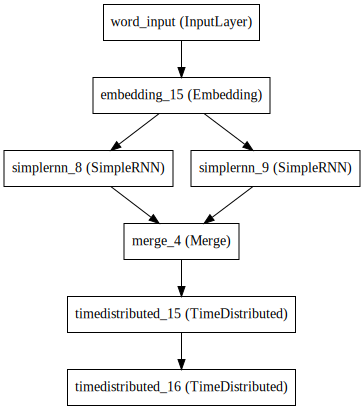

In [112]:
n_epochs              = 10    # Number of epochs
bidirectional         = True # Using bidirectional (True/False)
pretrained_embeddings = True  # Using pretrained embeddings (True/False)
rnn_type              = SimpleRNN  # One out of: SimpleRNN, GRU, LSTM
fancy                 = False # Use modern stuff (True/False) (Adds: Dropout, BatchNormalisation, ReLu)
deep                  = False # Add another layer of recurrent connections


model = build_rnn(bidirectional, pretrained_embeddings, rnn_type, fancy, deep)
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=[actual_accuracy,])
model.summary()

model.fit(train_X_rnn, train_y_rnn, validation_data=(dev_X_rnn, dev_y_rnn), nb_epoch=n_epochs, batch_size=10, verbose=2, callbacks=[EarlyStopping(monitor='val_loss', patience=2)]);
print('Evaluation - test_loss: {0:.4f} - test_acc: {1:.4f}'.format(*model.evaluate(test_X_rnn, test_y_rnn, batch_size=10, verbose=2)))
SVG(model_to_dot(model).create(prog='dot', format='svg'))

You should be able to get somewhere around 90 - 92% accuracy on both dev and test.
That's an error reduction of about 50% compared to a standard FFNN!

Let's do the same error analysis as in the previous case:

In [100]:
def rnn_predict_sentence(sent, model):
    word_ids = [word_to_id.get(word, word_to_id['_UNK']) for word in sent]
    padded = sequence.pad_sequences([word_ids], maxlen=max_sent_len, dtype=np.int32, value=word_to_id['<PAD>'])
    preds = model.predict_on_batch(padded)
    pred_pos = [tag for pred in preds[0] for tag, tag_id in tag_to_id.items() if tag_id == np.argmax(pred)]
    print('SNT: {0}'.format(sent))
    print('POS: {0}\n UNK:{1}'.format(pred_pos[-len(sent):], [idx==word_to_id['_UNK'] for idx in word_ids]))
    

sent = u'Det känns riktigt att ha ett riktigt yrke .'.split()
rnn_predict_sentence(sent, model)

SNT: [u'Det', u'k\xe4nns', u'riktigt', u'att', u'ha', u'ett', u'riktigt', u'yrke', u'.']
POS: [u'PRON', u'VERB', u'ADV', u'SCONJ', u'VERB', u'DET', u'ADJ', u'NOUN', u'PUNCT']
 UNK:[False, False, False, False, False, False, False, False, False]


We now get both types of 'riktigt' right, thanks to the RNN taking advantage of context.